<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/%ED%8C%80%ED%94%8C_Resnet(half_train2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


In [ ]:
SIZE=64
N_ch=3

In [ ]:
input_tensor = Input(shape=(SIZE, SIZE, N_ch))
conv_base = ResNet50(include_top=False, weights='imagenet',input_tensor=input_tensor,pooling='max')
conv_base.trainable = False
for layer in conv_base.layers[92:]:
    layer.trainable = True

In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
x = conv_base.output
output = layers.Dense(33, activation='softmax')(x)
model = Model(input_tensor, output)

#optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.adam(),metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}_halfFreeze.hdf5'
checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_acc',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=15)
my_callbacks = [checkpoint, annealer]

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 166s 332ms/step - loss: 0.0670 - accuracy: 0.9775 - val_loss: 1.7840 - val_accuracy: 0.6460
Epoch 2/50
  1/500 [..............................] - ETA: 1:07 - loss: 0.0492 - accuracy: 0.9844

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 161s 323ms/step - loss: 0.0594 - accuracy: 0.9807 - val_loss: 3.3717 - val_accuracy: 0.5754
Epoch 3/50
500/500 [==============================] - 163s 327ms/step - loss: 0.0580 - accuracy: 0.9809 - val_loss: 0.5610 - val_accuracy: 0.8723
Epoch 4/50
500/500 [==============================] - 160s 321ms/step - loss: 0.0547 - accuracy: 0.9810 - val_loss: 0.4382 - val_accuracy: 0.9249
Epoch 5/50
500/500 [==============================] - 162s 324ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.3500 - val_accuracy: 0.8775
Epoch 6/50
500/500 [==============================] - 160s 320ms/step - loss: 0.0527 - accuracy: 0.9819 - val_loss: 0.1872 - val_accuracy: 0.8902
Epoch 7/50
500/500 [==============================] - 161s 322ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.8408 - val_accuracy: 0.8468
Epoch 8/50
500/500 [==============================] - 163s 326ms/step - loss: 0.0471 - accuracy: 0.9838 - val_loss: 0.6209 - val_accura

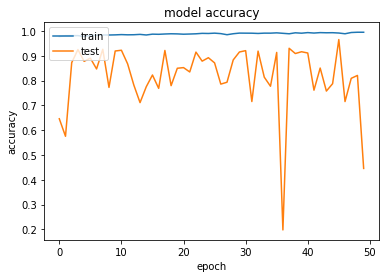

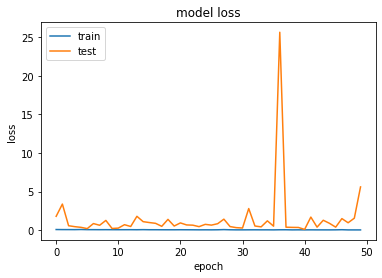

In [ ]:
# accuracy plot 
plt.plot(resnet.history['accuracy'])
plt.plot(resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

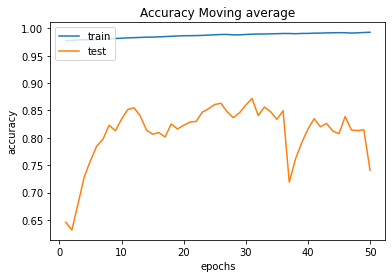

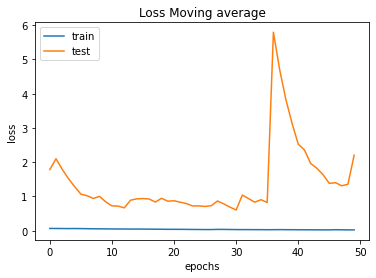

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(resnet.history['accuracy'])
smooth_mae_history_val = smooth_curve(resnet.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(smooth_curve(resnet.history['loss']))
plt.plot(smooth_curve(resnet.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Reduce On Pleateau lr값 조절. half train3이랑 똑같은데 이거는 런타임 안끄고한거

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}_halfFreeze2_lrEdit.hdf5'
checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_acc',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=15)
my_callbacks = [checkpoint, annealer]

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 164s 328ms/step - loss: 0.0190 - accuracy: 0.9942 - val_loss: 0.1640 - val_accuracy: 0.9328
Epoch 2/50
  1/500 [..............................] - ETA: 1:10 - loss: 2.7408e-04 - accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 162s 324ms/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 1.1028 - val_accuracy: 0.7988
Epoch 3/50
500/500 [==============================] - 160s 319ms/step - loss: 0.0221 - accuracy: 0.9928 - val_loss: 0.4929 - val_accuracy: 0.8867
Epoch 4/50
500/500 [==============================] - 163s 325ms/step - loss: 0.0168 - accuracy: 0.9942 - val_loss: 0.5936 - val_accuracy: 0.8250
Epoch 5/50
500/500 [==============================] - 159s 318ms/step - loss: 0.0217 - accuracy: 0.9939 - val_loss: 1.3666 - val_accuracy: 0.8443
Epoch 6/50
500/500 [==============================] - 162s 323ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 1.9760 - val_accuracy: 0.6612

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
500/500 [==============================] - 160s 320ms/step - loss: 0.0099 - accuracy: 0.9966 - val_loss: 0.1417 - val_accuracy: 0.9672
Epoch 8/50
500/500 [==============================] - 

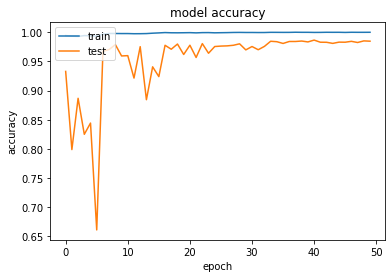

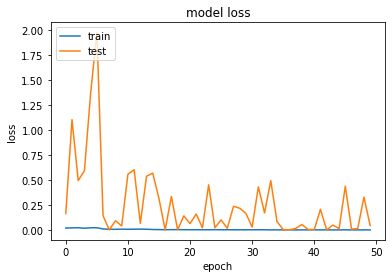

In [ ]:
# accuracy plot 
plt.plot(resnet.history['accuracy'])
plt.plot(resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

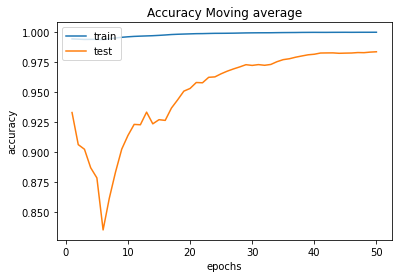

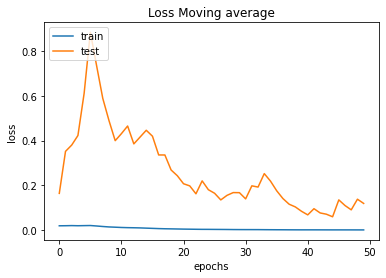

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(resnet.history['accuracy'])
smooth_mae_history_val = smooth_curve(resnet.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(smooth_curve(resnet.history['loss']))
plt.plot(smooth_curve(resnet.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

이전에 잘나온모델 저장용 (절반 레이어 학습1 - earlystop됨) 

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 167s 333ms/step - loss: 0.5354 - accuracy: 0.8663 - val_loss: 6.9757 - val_accuracy: 0.2894
Epoch 2/50
  1/500 [..............................] - ETA: 1:06 - loss: 0.9607 - accuracy: 0.7188

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 163s 326ms/step - loss: 0.8395 - accuracy: 0.7897 - val_loss: 1.2042 - val_accuracy: 0.7451
Epoch 3/50
500/500 [==============================] - 163s 325ms/step - loss: 0.4118 - accuracy: 0.8865 - val_loss: 203.9712 - val_accuracy: 0.3843
Epoch 4/50
500/500 [==============================] - 163s 325ms/step - loss: 0.3328 - accuracy: 0.9003 - val_loss: 1.3446 - val_accuracy: 0.8639
Epoch 5/50
500/500 [==============================] - 162s 324ms/step - loss: 0.2926 - accuracy: 0.9208 - val_loss: 0.3544 - val_accuracy: 0.8305
Epoch 6/50
500/500 [==============================] - 163s 326ms/step - loss: 0.2182 - accuracy: 0.9328 - val_loss: 0.7201 - val_accuracy: 0.8294
Epoch 7/50
500/500 [==============================] - 165s 330ms/step - loss: 0.2403 - accuracy: 0.9291 - val_loss: 0.7172 - val_accuracy: 0.8757
Epoch 8/50
500/500 [==============================] - 161s 323ms/step - loss: 1.3721 - accuracy: 0.7150 - val_loss: 360.0924 - val_ac

모델2 -얼리스탑 안걸었는데 reduce on pleateau lr 잘못줘서 무한반복중

In [ ]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=500,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
500/500 [==============================] - 166s 332ms/step - loss: 0.0670 - accuracy: 0.9775 - val_loss: 1.7840 - val_accuracy: 0.6460
Epoch 2/50
  1/500 [..............................] - ETA: 1:07 - loss: 0.0492 - accuracy: 0.9844

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


500/500 [==============================] - 161s 323ms/step - loss: 0.0594 - accuracy: 0.9807 - val_loss: 3.3717 - val_accuracy: 0.5754
Epoch 3/50
500/500 [==============================] - 163s 327ms/step - loss: 0.0580 - accuracy: 0.9809 - val_loss: 0.5610 - val_accuracy: 0.8723
Epoch 4/50
500/500 [==============================] - 160s 321ms/step - loss: 0.0547 - accuracy: 0.9810 - val_loss: 0.4382 - val_accuracy: 0.9249
Epoch 5/50
500/500 [==============================] - 162s 324ms/step - loss: 0.0712 - accuracy: 0.9777 - val_loss: 0.3500 - val_accuracy: 0.8775
Epoch 6/50
500/500 [==============================] - 160s 320ms/step - loss: 0.0527 - accuracy: 0.9819 - val_loss: 0.1872 - val_accuracy: 0.8902
Epoch 7/50
500/500 [==============================] - 161s 322ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.8408 - val_accuracy: 0.8468
Epoch 8/50
500/500 [==============================] - 163s 326ms/step - loss: 0.0471 - accuracy: 0.9838 - val_loss: 0.6209 - val_accura